# Coordinate Transformations and Visualization
This notebook gives some basic examples on how to converte between different coordinate systems, e.g. the HorizonFrame which gives the position on the sky or the CameraFrame which would be the position in a given camera.

Additionally a example is given, on how to display the array layout and adding the direction of the shower to this plot. In this context it is discussed, how the selection of a subarray is performed.

In [1]:
from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization
from ctapipe.reco.HillasReconstructor import \
        HillasReconstructor # direction reconstruction
from ctapipe.io.eventseeker import EventSeeker    # select specific event

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import os

from ctapipe.plotting.array import ArrayDisplay   # plot array layouts
%matplotlib inline

# coordinate frames
from ctapipe.coordinates import CameraFrame, HorizonFrame, GroundFrame,\
        TiltedGroundFrame, NominalFrame
from astropy.coordinates import SkyCoord

# Coordinate transformations

Lets look at the coordinates of some actual event to demonstrate the coordinate transformations in ctapipe.

In [2]:
file = os.path.expanduser("~/simtel_files/gamma_20deg_180deg_run1\
___cta-prod3_desert-2150m-Paranal-merged.simtel.gz")
source = event_source(file, max_events=15) # read the file

seeker = EventSeeker(source)
event = seeker[10]

# lets just perfome the calibration:
calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator")
calibrator.calibrate(event)

To do the transformation you need some informations about the telescope. Namely those are the pointing direction of the telescopes as well as the focal length.

In [3]:
tel_id = list(event.r0.tels_with_data)[1]

# pointing direction of telescope
pointing_az = event.mc.tel[tel_id].azimuth_raw * u.rad
pointing_alt = event.mc.tel[tel_id].altitude_raw * u.rad

# get a astropy SkyCoord for the pointing position
pointing = SkyCoord(
    alt=pointing_alt,
    az=pointing_az,
    frame='altaz')

# focal length of the telescope
focal_length = event.inst.subarray.tel[tel_id].\
            optics.equivalent_focal_length

Define the camera frame.

In [4]:
cf = CameraFrame(focal_length=focal_length,
                 array_direction=pointing,
                 pointing_direction=pointing)

Direction of event. As we are looking at a point source simulation file, this will be the same direction for all events in the source.

In [5]:
direction = HorizonFrame(alt=event.mc.alt,
                         az=event.mc.az)

Now we have defined the direction of the event in the horizon frame and also know the camera frame to look at. With this information we can see where this event is in the camera frame.

In [6]:
cam_coord = direction.transform_to(cf)

Plotting the calibrated camera image and the direction projected to the camera frame. Just as excpected for the point source simulation just in the pointing direction, the projected position is just in the center of the camera.

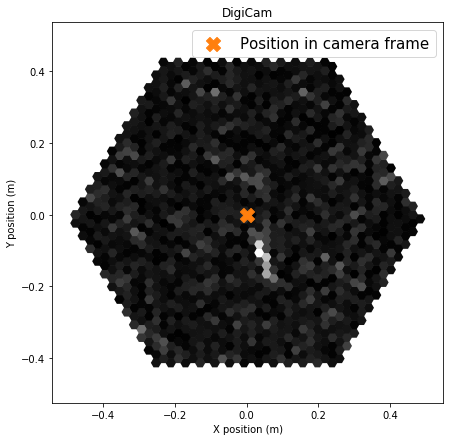

In [7]:
fig = plt.figure(figsize=[7,7])
CameraDisplay(event.inst.subarray.tels[tel_id].camera, image=event.dl1.tel[tel_id].image[0])
plt.scatter(cam_coord.x, cam_coord.y, s=200, marker="X", color="C1", label="Position in camera frame")
plt.legend(fontsize=15)

Convert to the NominalFrame. This system describes to angular offset between a given position towards the pointing direction of the array. As long as the pointing direction of the telescopes equals the pointing direction of the array, this will be the same as the TelescopeFrame. Only for divergent pointing those frames will be a different.

In [8]:
nf = NominalFrame(
            pointing_direction=HorizonFrame(alt=pointing_alt, az=pointing_az),
            array_direction=HorizonFrame(alt=pointing_alt, az=pointing_az)
        )

nom_coord = cam_coord.transform_to(nf)

print(nom_coord)

<NominalFrame Coordinate (pointing_direction=<HorizonFrame Coordinate (pointing_direction=None, array_direction=None): (az, alt) in deg
    (180.00000501, 69.99999967)>, array_direction=<HorizonFrame Coordinate (pointing_direction=None, array_direction=None): (az, alt) in deg
    (180.00000501, 69.99999967)>): (x, y) in rad
    (0., 0.)>


From the NominalCoordinat we can go back to the HorizonFrame to get the Azimuth and Altitude. This should be the same as the value we started in the beginning.

In [9]:
direction_new = nom_coord.transform_to(HorizonFrame)

print(direction_new)

assert direction_new.alt == direction.alt
assert direction_new.az == direction.az

<HorizonFrame Coordinate (pointing_direction=None, array_direction=None): (az, alt) in deg
    [(180.00000501, 69.99999967)]>


### Coordinates on the ground

We can start with GroundFrame which describes the position of an object relative to the ground level. Here lets look at the position of one telescope.

In [10]:
gf = GroundFrame(x=event.inst.subarray.positions[1][0],
                 y=event.inst.subarray.positions[1][1],
                 z=event.inst.subarray.positions[1][2])
gf

<GroundFrame Coordinate (pointing_direction=None): (x, y, z) in m
    (75.16100311, 0., 16.)>

We can transform this into the TiltedGroundFrame. This is the ground coordinates tilted according to the pointing direction and projected in a 2 dimensional plane perpendicular to the pointing direction.

In [11]:
gf = GroundFrame(x=1 * u.m,
                 y=1 * u.m,
                 z=0 * u.m)
print(gf)
tf = TiltedGroundFrame(pointing_direction=pointing)

tilt_coord = gf.transform_to(tf)
tilt_coord

<GroundFrame Coordinate (pointing_direction=None): (x, y, z) in m
    (1., 1., 0.)>


<TiltedGroundFrame Coordinate (pointing_direction=<SkyCoord (AltAz: obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    (180.00000501, 69.99999967)>): (x, y) in m
    (-0.93969254, -1.00000009)>

In the following I tryed to visualize this transformation with the description right underneath the plot

(-5.0, 5.0, -5.0, 5.0)

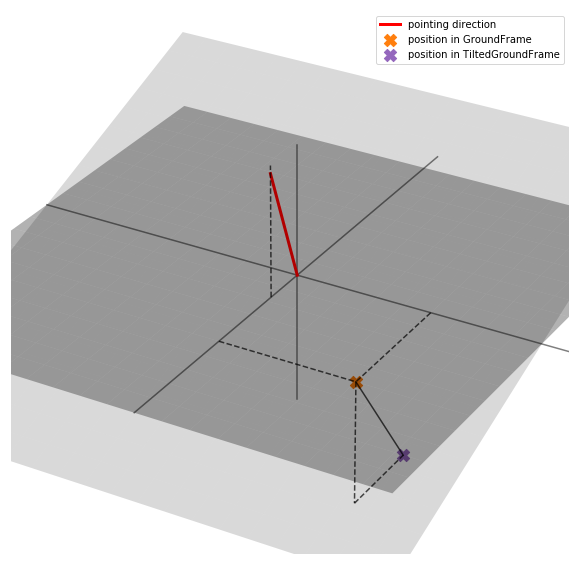

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Add some axis for orientation
plt.plot([-10, 10], [0,0], [0,0], color="k", alpha=0.5)
plt.plot([0, 0], [10,-10], [0,0], color="k", alpha=0.5)
plt.plot([0, 0], [0,0], [5,-5], color="k", alpha=0.5)

r = np.arange(-10,10)
xx, yy = np.meshgrid(r, r)
# GroundFrame
zz = np.zeros([len(r), len(r)])
ax.plot_surface(xx, yy, zz, alpha=0.3, color="k")

# TiltedGroundFrame
for ii, x in enumerate(xx):
    for jj, y in enumerate(yy[:,1]):
        zz[ii][jj] = np.sin(20*u.deg) * y
ax.plot_surface(xx, yy, np.transpose(zz), alpha=0.15, color="0")



# Show the pointing direction of the array
plt.plot([0, 0], [0, -5 * np.sin(20*u.deg)] , [0, 5 * np.cos(20*u.deg)],
         label="pointing direction", color="r", linewidth=3)
plt.plot([0, 0], [-5 * np.sin(20*u.deg), -5 * np.sin(20*u.deg)] , [0, 5 * np.cos(0*u.deg)],
         linestyle="--", color="k", alpha=0.7)

# Some position in the GroundFrame
ax.scatter(5,-5,0, marker="X", color="C1", s=150, label="position in GroundFrame")
plt.plot([5,5], [0,-5], [0,0], linestyle="--", color="k", alpha=0.7)
plt.plot([0,5], [-5,-5], [0,0], linestyle="--", color="k", alpha=0.7)

# Project it to the TiltedGroundFrame
ax.scatter(5, -5 * np.sin(20*u.deg), -5*np.cos(20*u.deg), marker="X", color="C4",
           s=150, label="position in TiltedGroundFrame")
plt.plot([5,5], [-5, -5* np.sin(20*u.deg)], [-5*np.cos(20*u.deg), -5*np.cos(20*u.deg)],
         linestyle="--", color="k", alpha=0.7)
plt.plot([5,5], [-5, -5], [0, -5*np.cos(20*u.deg)],
         linestyle="--", color="k", alpha=0.7)
plt.plot([5,5], [-5, -5* np.sin(20*u.deg)], [0, -5*np.cos(20*u.deg)],
         color="k", alpha=0.7)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-5, 5)

ax.legend()
plt.axis('off')

The darker gray plane represents the ground frame while the TiltedGroundFrame is given by the lighter gray plane. This is obtained by rotating the first plane to be perpendicular to the pointing direction of the camera in red. In this case it would simply be a rotation around the x axis. The position in the TiltedGroundFrame then is obtained by projecting a position to this new plane.  
Luckily astropys coordinate transformations makes it more simple than this to deal with those transformations.

# Array Display

A detailes description of the analysis steps can be found here. Each event runs through calibration, cleaning and parametrization. The Hillas parameters of each telescope of the event are stored in a dictionary parameters
In this analysis additionally a selection of the subarray is performed. The layout for this analysis can be found in here. By setting  
`source.allowed_tels = layout`  
where layout is a set of telescope IDs, the telescopes not in layout are removed from the `tels_with_dat` set in the event container. Therefore, when doing the loop ofer the telescopes  
```for tel_id in event.r0.tels_with_data:
    pass```  
only the desired telescopes are selected.

For plotting the array layout, `ArrayDisplay` is used which provides a method to draw the directions of the large semi-major axes of the Hillas ellipses. As `source.allowed_tel` does not change `event.inst.subarray` (which is considered in `ArrayDisplay`) a copy of the array description with only the desired telescopes is made:  
`subarray = event.inst.subarray.select_subarray("Paranel", layout)`

To plot the array layout you can simply call  
```AD = ArrayDisplay(subarray=subarray)
AD.set_line_hillas(parameters, range=1000)
```  
for adding the direction of the semi-major axes.

In [13]:
# Setting some thresholds for the analysis

# thresholds for tailcuts, not optimized!
tail_thresholds = {
    "ASTRICam": (5, 7),
    "FlashCam": (12, 15),
    "LSTCam": (5, 10),
    "NectarCam": (4, 8),
    "DigiCam": (3, 6),
    "CHEC": (2, 4),
    "SCTCam": (1.5, 3)}

# Thresholds for gain channel selection
pe_thresh = {
    "ASTRICam": 14,
    "LSTCam": 100,
    "NectarCam": 190}

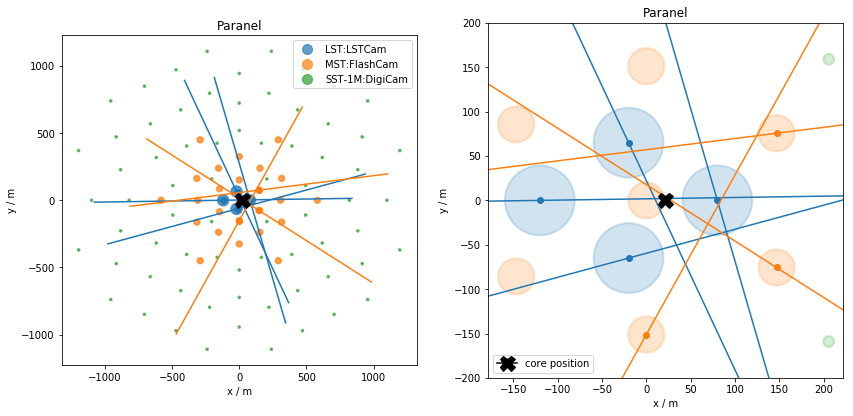

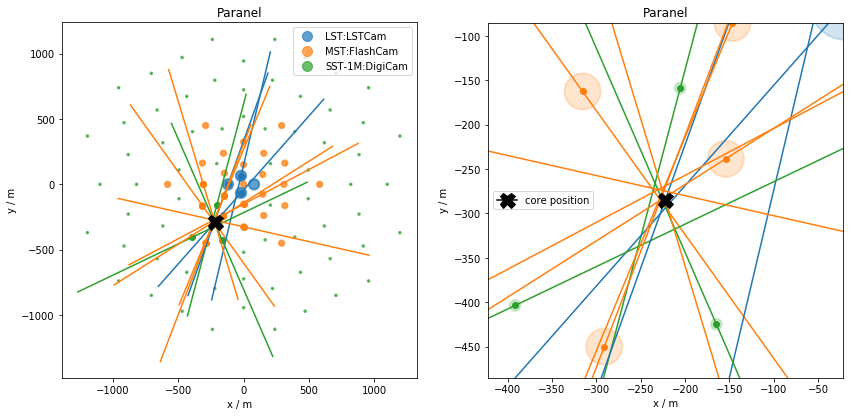

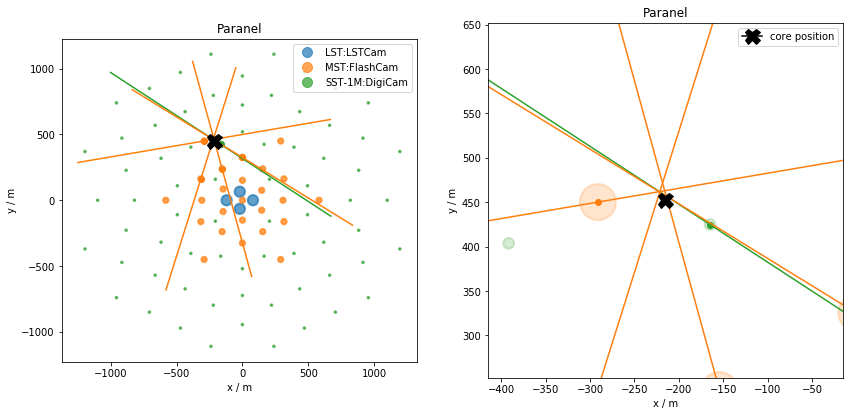

In [14]:
file = os.path.expanduser("~/simtel_files/gamma_20deg_180deg_run1\
___cta-prod3_desert-2150m-Paranal-merged.simtel.gz")

# load a layout
layout = set(np.loadtxt("./ArrayLayouts/CTA.prod3Sb.3HB9-FD.txt"))

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator")

source = event_source(file, max_events=10) # read the file

# remove files not in layout from event.r0.tels_with_data
source.allowed_tels = layout

event = next(iter(source))
# get inst.subarray for this layout
subarray = event.inst.subarray.select_subarray("Paranel", layout)

# start the main loop
for event in source:
    calibrator.calibrate(event) # fill r1, dl0 and dl1

    # dicts for the direction reconstruction
    parameters = {}

    for tel_id in event.r0.tels_with_data: # only telescopes specified in layout
        
        camera = event.inst.subarray.tel[tel_id].camera

        if camera.cam_id in pe_thresh.keys():
            image, mask = pick_gain_channel(
                event.dl1.tel[tel_id].image, pe_thresh[camera.cam_id],
                select_by_sample=True)

        else:
            # get correct shape for cleaning
            image = np.squeeze(event.dl1.tel[tel_id].image)

        #cleaning
        mask = tailcuts_clean(camera, image=image,
                              picture_thresh=tail_thresholds[camera.cam_id][1],
                              boundary_thresh=tail_thresholds[camera.cam_id][0],
                              min_number_picture_neighbors=2)
        if not any(mask):
            # no pixel has survived the cleaning
            # move to next telescope
            continue

        cleaned_image = np.copy(image) 
        cleaned_image[~mask] = 0
        hillas_params = hillas_parameters(camera, cleaned_image)

        # collect parameters needed for direction reconstruction
        parameters[tel_id] = hillas_params
        
    if len(parameters) < 3:
        # plot events with at least 3 telescopes survived
        continue

        
    # Plot the layout:
    fig = plt.figure(figsize=[14,7])
    ax1 = fig.add_subplot(121)
    ad = ArrayDisplay(subarray=subarray, axes=ax1)
    ad.set_line_hillas(parameters, range=1000)
    
    # zoom in to core position
    ax2 = fig.add_subplot(122)
    ad2 = ArrayDisplay(subarray=subarray, axes=ax2, alpha=0.2)
    ad2.set_line_hillas(parameters, range=1000)
    ax2.set_ylim([event.mc.core_y.value-200, event.mc.core_y.value+200])
    ax2.set_xlim([event.mc.core_x.value-200, event.mc.core_x.value+200])
    
    for ax in ax1, ax2:
        ax.plot(event.mc.core_x, event.mc.core_y, marker="X", markersize=15,
                 color="k", label="core position")
        ax.set_xlabel("x / m")
        ax.set_ylabel("y / m")
    
    ax2.legend()
    
    plt.show()

As expected most of the large semi-major axes for the parameterized images points towards the core position of the shower. However, this is highly dependent on the image cleaning as well as the leakage handeling which is not considered at all in this analysis.

This is the basic of the geometrical direction reconstruction like `HillasReconstructor`.